# Uncertainty vs Likelihood

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json 
import gzip
from collections import defaultdict

In [2]:
import GPy
import plotly

In [3]:
GPy.plotting.change_plotting_library('matplotlib')

# Data generating process 

This is an artificial process, but shows how challenging it is to learn a hidden pattern. 

We pair an input x in the real line with 1 if a periodic function of x is positive, and 0, otherwise.

In [4]:
gold_fn = lambda x: (np.sign(np.sin(x*10)) > 0 )* 1

Some observations

In [5]:
X = np.random.uniform(-2.,2., 100)
Y = gold_fn(X)

In [6]:
X_id = np.random.uniform(-2.,2., 100)
Y_id = gold_fn(X_id)

In [7]:
X_od1 = np.random.beta(0.2, 0.2, 100) * 1
Y_od1 = gold_fn(X_od1)

X_od2 = np.random.beta(0.2, 0.2, 100) * 10
Y_od2 = gold_fn(X_od2)

X_od3 = np.random.beta(0.2, 0.2, 100) * 20
Y_od3 = gold_fn(X_od3)

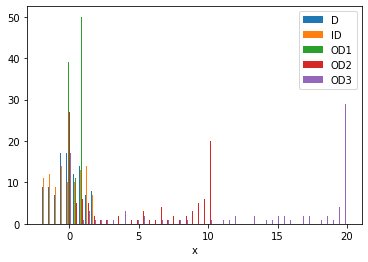

In [8]:
_ = plt.hist([X, X_id, X_od1, X_od2, X_od3], bins=50, label=['D', 'ID', 'OD1', 'OD2', 'OD3'])
plt.xlabel('x')
plt.legend()

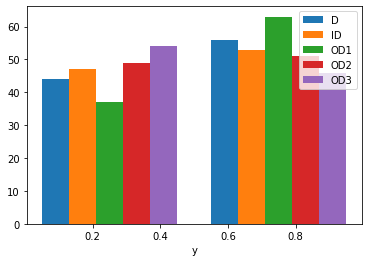

In [9]:
_ = plt.hist([Y, Y_id, Y_od1, Y_od2, Y_od3], bins=2, label=['D', 'ID', 'OD1', 'OD2', 'OD3'])
plt.xlabel('y')
plt.legend()

# RBF GP

In [10]:
def gp_accuracy(model, test):
    equals = (model.log_predictive_density(test[:, None], np.ones_like(test[:,None]))[:, 0] > np.log(0.5)) == gold_fn(test)
    return sum(equals) / len(test)

In [11]:
def gp_log_evidence(model, test):
    return model.log_predictive_density(test[:, None], gold_fn(test)[:, None])[:, 0].sum()

In [12]:
def gp_p1(model, test):
    return np.exp(model.log_predictive_density(test[:, None], np.ones_like(test[:, None])))[:, 0]

In [13]:
gp1 = GPy.models.GPClassification(
    X[:, None], 
    Y[:, None], 
    GPy.kern.RBF(1, variance=1, lengthscale=0.1)
)

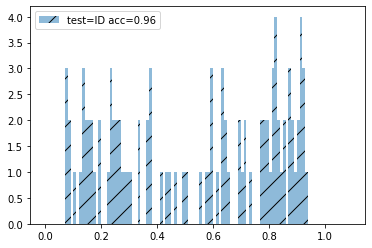

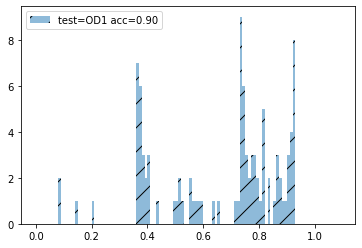

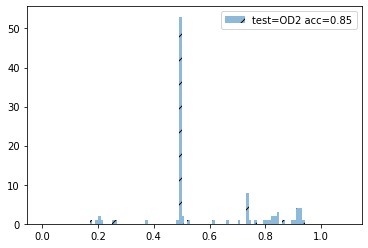

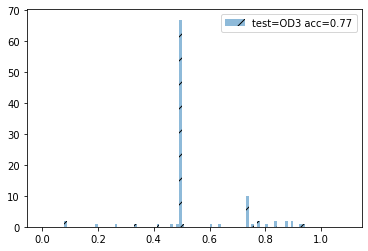

In [29]:
for (test, name) in [(X_id, 'ID'), (X_od1, 'OD1'), (X_od2, 'OD2'), (X_od3, 'OD3')]:
    acc = gp_accuracy(gp1, test)
    p1 = gp_p1(gp1, test)
    _ = plt.hist(p1, bins=np.arange(0., 1.1, 0.01), label='test={:s} acc={:.2f}'.format(name, acc), alpha=0.5, hatch='/')
    plt.legend()
    plt.show()

Note how the GP gets less and less confident as we distance ourselves from the data.  

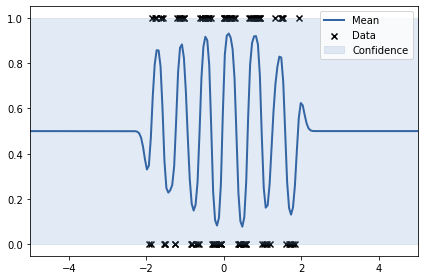

In [36]:
fig = gp1.plot(plot_limits=[-5,5]Wilker Aziz)

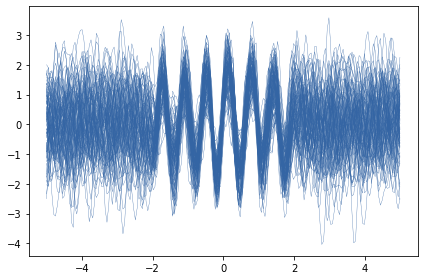

In [16]:
_ = gp1.plot_samples(samples=100, plot_limits=[-5,5])

In these plots it is very clear that the GP with RBF kernel is not confident in extrapolating the observed pattern.

# Periodic GP

Here we use a Kernel that prefers periodic functions. Of course, we are cheating, as we know that the data generating process is indeed periodic. The point is to show the effect of a structured prior.

In [17]:
gp2 = GPy.models.GPClassification(
    X[:, None], 
    Y[:, None], 
    GPy.kern.PeriodicMatern52(lengthscale=0.1)
)

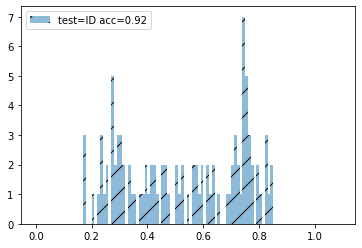

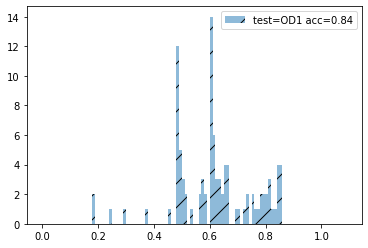

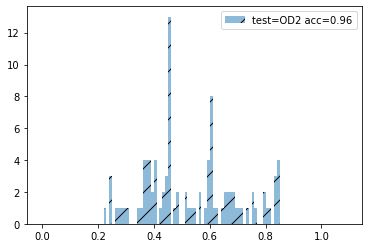

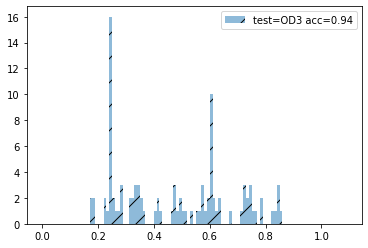

In [18]:
for (test, name) in [(X_id, 'ID'), (X_od1, 'OD1'), (X_od2, 'OD2'), (X_od3, 'OD3')]:
    acc = gp_accuracy(gp2, test)
    p1 = gp_p1(gp2, test)
    _ = plt.hist(p1, bins=np.arange(0., 1.1, 0.01), label='test={:s} acc={:.2f}'.format(name, acc), alpha=0.5, hatch='/')
    plt.legend()
    plt.show()

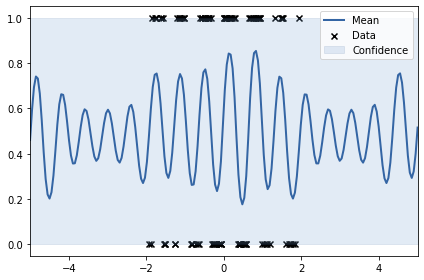

In [19]:
Wilker Azizfig = gp2.plot(plot_limits=[-5,5])

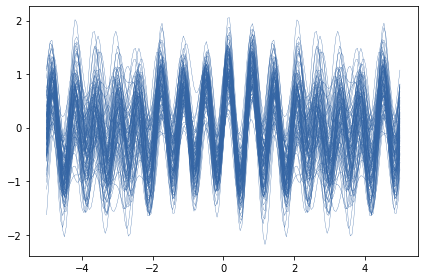

In [20]:
_ = gp2.plot_samples(samples=100, plot_limits=[-5,5])

Note how the mean pattern is extrapolated both to the left and to the right of the observations. 

# NN


In [21]:
import sklearn

In [22]:
from sklearn.neural_network import MLPClassifier

In [44]:
cls = MLPClassifier(hidden_layer_sizes=(1000,), max_iter=5000)

In [45]:
cls.fit(X[:, None], Y)

MLPClassifier(hidden_layer_sizes=(1000,), max_iter=5000)

In [46]:
def nn_accuracy(model, test):
    acc = sum(model.predict(test[:, None]) == gold_fn(test)) / len(X)
    return acc

In [47]:
def nn_p1(model, test):
    return model.predict_proba(test[:, None])[:, 1]

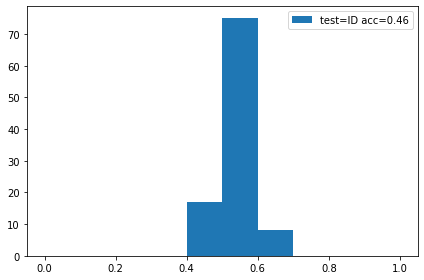

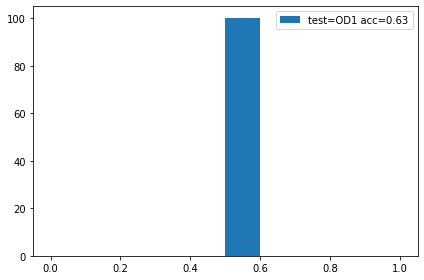

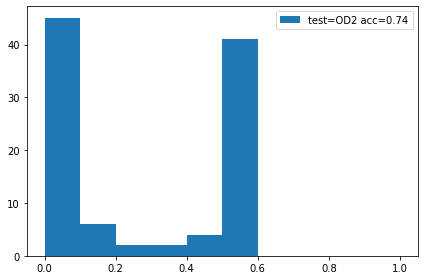

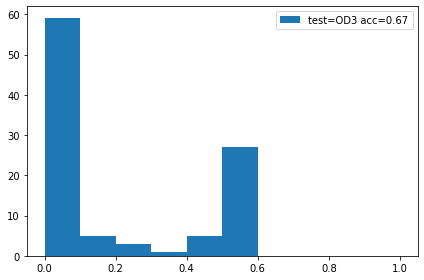

<Figure size 432x288 with 0 Axes>

In [48]:
for (test, name) in [(X_id, 'ID'), (X_od1, 'OD1'), (X_od2, 'OD2'), (X_od3, 'OD3')]:     
    acc = nn_accuracy(cls, test)
    _= plt.hist(nn_p1(cls, test), 
                bins=np.arange(0, 1.1, 0.1), label='test={:s} acc={:.2f}'.format(name, acc))

    plt.legend()
    plt.tight_layout()
    plt.show()
plt.savefig('bin-classification-NN.png')

Note how if we interpret **likelihood** as uncertainty, the NN gets more and more confident as we distance ourselves from the data.

# BNN

[Neal, 1994](https://www.cs.toronto.edu/~radford/ftp/pin.pdf)

In [216]:
def fn(h, activation):
    if activation == 'step':
        return np.heaviside(h, 0)
    elif activation == 'relu':
        return np.maximum(h, 0)
    elif activation == 'sigmoid':
        return 1/(1 + np.exp(-h)) 
    elif activation == 'softplus':
        return np.log1p(np.exp(h))
    elif activation == 'tanh':
        return np.tanh(h)
    elif activation == 'abs':
        return np.abs(h)
    else:  # linear
        return h

In [237]:
def bnn(x, activation='tanh', H=100, su=1., sa=1., sv=1., sb=1.):
    """
    I use the notation of [Neal, 1994](https://www.cs.toronto.edu/~radford/ftp/pin.pdf)
    """
    U = np.random.normal(0, su, [H, 1]).transpose()
    a = np.random.normal(0, sa, [H, 1]).transpose()
    V = np.random.normal(0, sv, [1, H]).transpose()
    b = np.random.normal(0, sb, [1, 1]).transpose()
    return np.matmul(fn(np.matmul(x, U) + a, activation), V) + b

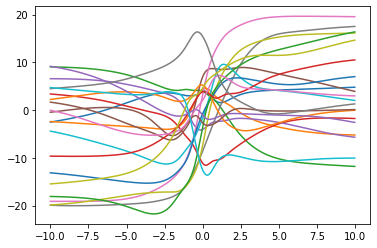

In [246]:
inputs = np.linspace(-10, 10, 1000)
for i in range(20):
    _ = plt.plot(
        inputs[:, None], 
        bnn(inputs[:, None], 'tanh'), 
        '-', markersize=0.5)